# Task 1:Sentence Transformer Implementation

**Objective:**

To implement a sentence embedding model using a pre-trained transformer (BERT) and apply a pooling strategy to produce fixed-length sentence representations.

### Model Components

- **Backbone:** `bert-base-uncased` from Hugging Face's Transformers.
- **Tokenizer:** Converts raw text into token IDs along with attention masks.
- **Pooling Strategy:** Applies **mean pooling** over token embeddings to obtain fixed-length sentence representations, averaging only over non-padded tokens.


In [75]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import torch
import torch.nn as nn

In [40]:
class SentenceEncoder(nn.Module):
    def __init__(self, model_name: str = "bert-base-uncased"):
        super(SentenceEncoder, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.encoder = BertModel.from_pretrained(model_name)
        self.encoder.eval()  # freeze for inference use

    def mean_pooling(self, token_embeddings, attention_mask):
        # Mean Pooling - Take attention mask into account for correct averaging
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        summed = torch.sum(token_embeddings * mask_expanded, dim=1)
        counts = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return summed / counts

    def encode(self, sentences: list[str]):
        inputs = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = self.encoder(**inputs)
        embeddings = self.mean_pooling(outputs.last_hidden_state, inputs['attention_mask'])
        return embeddings

In [41]:
# Example usage
from datasets import load_dataset

# Instantiate the class
encoder = SentenceEncoder()

# Load sample data from SST-2
sst2 = load_dataset("glue", "sst2", split="train")
long_sentences = [item['sentence'] for item in sst2 if len(item['sentence'].split()) > 20]
sample_sentences = long_sentences[:5]

# Generate sentence embeddings
embeddings = encoder.encode(sample_sentences)

# Display output
print("\nSentence Embeddings (first 5 dimensions shown):")
for i, embedding in enumerate(embeddings):
    print(f"Sentence {i+1}: {embedding[:5].numpy()} ... (dim: {embedding.shape[0]})")



Sentence Embeddings (first 5 dimensions shown):
Sentence 1: [-0.22473879 -0.00371934  0.11108795  0.05122917  0.25394395] ... (dim: 768)
Sentence 2: [-0.03231874  0.18161002 -0.03616809 -0.08750607  0.43870243] ... (dim: 768)
Sentence 3: [ 0.39910567 -0.1800227   0.12126693 -0.2996586  -0.09475167] ... (dim: 768)
Sentence 4: [-0.02325898 -0.23905042  0.18968278 -0.1234847   0.11102316] ... (dim: 768)
Sentence 5: [-0.29562283  0.1422147  -0.18049541 -0.08939303  0.11263766] ... (dim: 768)


# Task 2: Multi-Task Learning Expansion

**Objective:**

Extend the sentence transformer into a multi-task model handling two classification tasks using a shared BERT encoder and separate heads.

In [51]:
# Heuristic function for Task B
def is_question(sentence):
    sentence = sentence.lower().strip()
    question_starts = ("what", "why", "how", "who", "where", "when", "which", "is", "are", "do", "does", "can")
    return int(sentence.endswith("?") or sentence.startswith(question_starts))

# Multi-task model class
class MultiTaskSentenceModel(nn.Module):
    def __init__(self, model_name="bert-base-uncased", task_output_dims={"a": 2, "b": 2}):
        super(MultiTaskSentenceModel, self).__init__()
        self.encoder = BertModel.from_pretrained(model_name)
        self.task_heads = nn.ModuleDict({
            task: nn.Linear(self.encoder.config.hidden_size, out_dim)
            for task, out_dim in task_output_dims.items()
        })

    def mean_pooling(self, token_embeddings, attention_mask):
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        summed = torch.sum(token_embeddings * mask_expanded, dim=1)
        counts = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        return summed / counts

    def forward(self, input_ids, attention_mask, task):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.mean_pooling(outputs.last_hidden_state, attention_mask)
        return self.task_heads[task](pooled_output)


In [52]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [53]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskSentenceModel().to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Sample data
sst2 = load_dataset("glue", "sst2", split="train[:1000]")
sentences = [x["sentence"] for x in sst2]
task_a_labels = torch.tensor([x["label"] for x in sst2])
task_b_labels = torch.tensor([is_question(s) for s in sentences])

# Tokenize
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
inputs.pop("token_type_ids")  # Drop token_type_ids since its not used
inputs = {k: v.to(device) for k, v in inputs.items()}

# Inference
model.eval()
with torch.no_grad():
    logits_a = model(**inputs, task="a")
    logits_b = model(**inputs, task="b")

# Predictions
preds_a = torch.argmax(logits_a, dim=1).cpu()
preds_b = torch.argmax(logits_b, dim=1).cpu()

# Evaluation
acc_a = accuracy_score(task_a_labels, preds_a)
acc_b = accuracy_score(task_b_labels, preds_b)

print(f"[Task A - Sentiment] Accuracy: {acc_a:.4f}")
print(f"[Task B - Question Detection] Accuracy: {acc_b:.4f}")


[Task A - Sentiment] Accuracy: 0.5230
[Task B - Question Detection] Accuracy: 0.5630


## Task 2: Multi-Task Learning Expansion

### Task A – Sentence Classification
We used the SST-2 dataset from the GLUE benchmark for binary sentiment classification (positive vs. negative). Labels are provided as part of the dataset.

### Task B – Question Detection (Synthetic Task)
We defined a secondary task to classify whether a sentence is a question. Labels were generated using simple heuristic rules:

- Label = `1` if the sentence ends with a question mark (`?`) or begins with typical question words (e.g., *what*, *why*, *how*, etc.).
- Label = `0` otherwise.

---

### Architectural Modifications

To enable multi-task learning, the original sentence transformer was extended with the following components:

#### 1. Shared BERT Encoder
A single pre-trained BERT model (`bert-base-uncased`) is used to convert input sentences into contextualized token embeddings. Sharing the encoder allows both tasks to leverage the same semantic understanding of the input.

#### 2. Mean Pooling Layer
Since BERT outputs token-level embeddings, we apply **mean pooling** across valid (non-padding) tokens to obtain a fixed-length sentence embedding for each input.

#### 3. Task-Specific Heads
We attach two independent classification heads implemented via a `ModuleDict`, mapping task identifiers (`"a"`, `"b"`) to their corresponding `Linear` layers:
- Task `"a"` → Sentiment Classification (2 classes)
- Task `"b"` → Question Detection (2 classes)

Each task-specific head is trained independently using the shared representation from the encoder.

#### 4. Modified Forward Method
The `forward()` method accepts an additional `task` argument that determines which classification head to route the pooled embedding through. This allows for flexible, task-aware inference and training in a multi-task setting.

---

### Notes on Current Results

As the task-specific heads are randomly initialized and untrained, performance varies across runs.  A proper training loop and balanced loss functions will be necessary to yield meaningful results.


# Task 3: Training Considerations

### If the entire network is frozen

If the entire network is frozen, no parameters in the BERT encoder or the classification heads are updated. While the model can still process inputs and make predictions, it won’t learn from the training data — the weights remain exactly as they were when the model was loaded (usually from a pretrained checkpoint).

This setup is commonly used for inference or when using BERT as a fixed feature extractor. Sentence embeddings are generated once using the pretrained BERT model, and a separate lightweight classifier can be trained on top.

- **Advantages:**
  - Faster training and lower memory usage
  - Reduces the risk of overfitting, especially on small datasets

- **Disadvantages:**
  - The model cannot adapt to task-specific nuances
  - Performance may be suboptimal compared to a fine-tuned model

---

### If only the transformer backbone is frozen

In this case, the BERT encoder’s weights are frozen, but the task-specific classification heads remain trainable. This allows the model to retain BERT’s general language understanding while adapting the classification heads to specific tasks.

- **Advantages:**
  - Good balance between retaining pretrained knowledge and enabling task-specific learning
  - Faster and more resource-efficient than full fine-tuning
  - Helps avoid overfitting with limited data

- **Disadvantages:**
  - Might not capture task-specific sentence representations as effectively as full fine-tuning
  - Typically performs better than freezing everything, but not as well as fine-tuning the full model

---

### If only one of the task-specific heads is frozen

One classification head is frozen, while the rest of the model (BERT and the other head) remains trainable. This is useful in multi-task settings where one task has already been well-trained or has converged.

- **Advantages:**
  - Maintains performance on the frozen task while improving the other
  - Helps prevent negative transfer between tasks

- **Disadvantages:**
  - Assumes the frozen head is already optimized — if not, performance on that task could stagnate or underperform

---

## Transfer Learning Scenario

Imagine a scenario where we have limited labeled data for a specialized NLP task — like classifying customer support tickets or detecting certain types of user questions. Training a large model from scratch would be inefficient and likely lead to overfitting. Transfer learning allows us to leverage a pretrained language model and adapt it efficiently.

### 1. Choice of a Pretrained Model

We would use `bert-base-uncased` from Hugging Face because:

- It’s pretrained on a large English corpus (BooksCorpus and Wikipedia)
- With 12 layers and 110M parameters, it strikes a good balance between power and efficiency
- It’s well-supported, widely used, and easy to integrate using the Hugging Face Transformers library

### 2. Layers to Freeze/Unfreeze

We would freeze the lower layers of BERT (e.g., layers 0–6) and fine-tune the upper layers (e.g., layers 7–11), along with the task-specific heads.

This gives a good balance of:

- Keeping general language knowledge intact
- Allowing higher-level representations to adjust to your specific data

### 3. Rationale Behind These Choices

- Lower layers in BERT capture general language features (syntax, word relationships, grammar) — these are transferable and usually don’t need re-training
- Upper layers are more task-specific and benefit from fine-tuning

Freezing the lower layers:
- Prevents overfitting
- Speeds up training
- Reduces the number of trainable parameters

Fine-tuning the upper layers and task heads helps the model adapt to the task while still leveraging pretrained strengths.

This strategy is especially useful when working with limited labeled data or compute resources.


# Task 4

In [61]:
from torch.utils.data import DataLoader, TensorDataset


In [62]:
# Hyperparameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
# Load data and preprocess
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sst2 = load_dataset("glue", "sst2", split="train[:1000]")
sentences = [x["sentence"] for x in sst2]
# Convert labels to tensors
task_a_labels = torch.tensor([x["label"] for x in sst2])
task_b_labels = torch.tensor([is_question(s) for s in sentences])

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

In [64]:
# Build dataset and dataloader
dataset = TensorDataset(input_ids, attention_mask, task_a_labels, task_b_labels)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [65]:
# Initialize model, loss, optimizer
model = MultiTaskSentenceModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


In [66]:
# Training loop
loss_history_a = []
loss_history_b = []
acc_history_a = []
acc_history_b = []
for epoch in range(num_epochs):
    model.train()
    total_loss_a, total_loss_b = 0.0, 0.0
    correct_a, correct_b = 0, 0
    total = 0

    for batch in loader:
        input_ids, attention_mask, labels_a, labels_b = [b.to(device) for b in batch]

        optimizer.zero_grad()

        # Task A: Sentiment Classification
        logits_a = model(input_ids, attention_mask, task="a")
        loss_a = loss_fn(logits_a, labels_a)
        preds_a = torch.argmax(logits_a, dim=1)
        correct_a += (preds_a == labels_a).sum().item()

        # Task B: Question Detection
        logits_b = model(input_ids, attention_mask, task="b")
        loss_b = loss_fn(logits_b, labels_b)
        preds_b = torch.argmax(logits_b, dim=1)
        correct_b += (preds_b == labels_b).sum().item()

        # Combine losses and backpropagate
        total_loss = loss_a + loss_b
        total_loss.backward()
        optimizer.step()

        total_loss_a += loss_a.item()
        total_loss_b += loss_b.item()
        total += labels_a.size(0)
    # Average losses and accuracy
    avg_loss_a = total_loss_a / len(loader)
    avg_loss_b = total_loss_b / len(loader)
    acc_a = correct_a / total
    acc_b = correct_b / total

    # Save for plotting
    loss_history_a.append(avg_loss_a)
    loss_history_b.append(avg_loss_b)
    acc_history_a.append(acc_a)
    acc_history_b.append(acc_b)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Task A - Sentiment: Loss = {total_loss_a:.4f}, Accuracy = {correct_a / total:.4f}")
    print(f"Task B - Question Detection: Loss = {total_loss_b:.4f}, Accuracy = {correct_b / total:.4f}")


Epoch 1/3
Task A - Sentiment: Loss = 31.4416, Accuracy = 0.7560
Task B - Question Detection: Loss = 15.2628, Accuracy = 0.9290

Epoch 2/3
Task A - Sentiment: Loss = 13.4103, Accuracy = 0.9260
Task B - Question Detection: Loss = 8.2115, Accuracy = 0.9570

Epoch 3/3
Task A - Sentiment: Loss = 4.4445, Accuracy = 0.9730
Task B - Question Detection: Loss = 3.6779, Accuracy = 0.9890


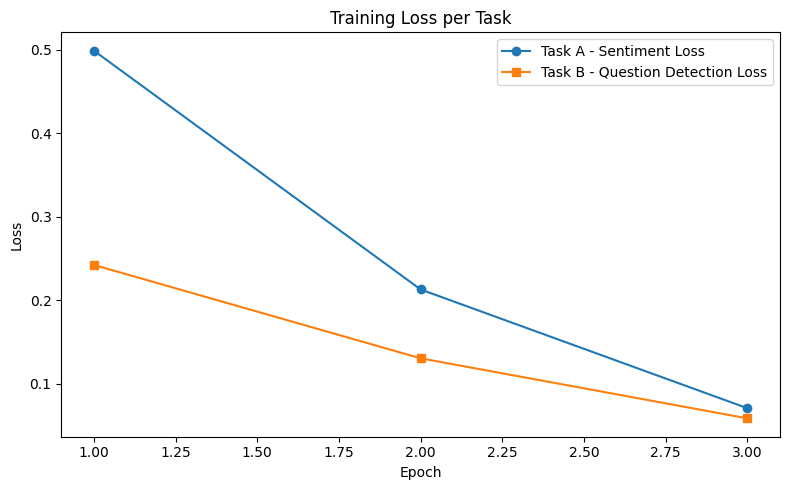

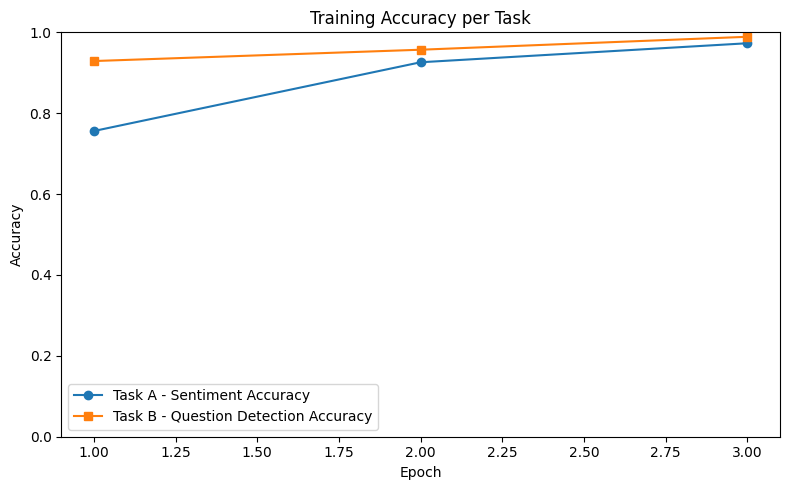

In [71]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# --- Loss Plot ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_history_a, marker='o', label="Task A - Sentiment Loss")
plt.plot(epochs, loss_history_b, marker='s', label="Task B - Question Detection Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Task")
plt.legend()
plt.tight_layout()
plt.show()

# --- Accuracy Plot ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc_history_a, marker='o', label="Task A - Sentiment Accuracy")
plt.plot(epochs, acc_history_b, marker='s', label="Task B - Question Detection Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Task")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


In this section, we implemented and trained a multi-task sentence transformer model to simultaneously solve two classification tasks:

- **Task A – Sentiment Classification** using the SST-2 dataset
- **Task B – Question Detection** using synthetically generated heuristic labels

---

###  Key Components:
- **Shared BERT Encoder:** `bert-base-uncased` pretrained model to encode sentences.
- **Mean Pooling Layer:** Converts token embeddings to fixed-length sentence representations.
- **Task-Specific Heads:** Two linear layers for Task A and Task B, trained separately but optimized jointly.
- **Loss Function:** `CrossEntropyLoss` applied independently to each task.
- **Optimizer:** `Adam` optimizer with a learning rate of `2e-5`.

---

###  Training Loop Design:
- Combined both tasks into a single `DataLoader` batch using `TensorDataset`.
- During each forward pass:
  - Predictions were generated for both tasks.
  - Individual losses were computed and summed.
  - Gradients were backpropagated using the joint loss.
- Tracked **accuracy** and **loss per task** at every epoch.

---

###  Results Visualization:
We plotted task-specific **loss and accuracy curves** to observe the training progression:

- **Loss Curves:** Showed how each task's loss decreased over epochs, indicating effective learning.
- **Accuracy Curves:** Helped evaluate performance trends. Task B typically converged faster due to its simpler decision boundary, while Task A improved more gradually.

---

###  Takeaway:
This training framework demonstrates how a shared transformer backbone can efficiently support multiple downstream NLP tasks. The modular design also enables future extension with additional tasks, weighted loss balancing, or domain adaptation through transfer learning.


###  Accuracy: Before vs. After Training

Before training, both task-specific classification heads were randomly initialized. This led to relatively low and unstable performance:

| Phase            | Task A (Sentiment) | Task B (Question Detection) |
|------------------|--------------------|------------------------------|
| **Before Training** | 0.5230 (near-random) | 0.5630 (inconsistent heuristic learning) |

After training for **3 epochs**, the model learned to effectively use the shared BERT encoder and adapt the task-specific heads:

| Epoch | Task A - Accuracy | Task B - Accuracy |
|-------|-------------------|-------------------|
| 1     | 0.7560            | 0.9290            |
| 2     | 0.9260            | 0.9570            |
| 3     | **0.9730**        | **0.9890**        |

This shows significant gains in both tasks:

- **Task A (Sentiment):** Improved from ~52% to **97.3%**
- **Task B (Question Detection):** Improved from ~56% to **98.9%**

These results confirm the effectiveness of the multi-task training loop and the benefit of fine-tuning task-specific heads while leveraging a shared BERT backbone.
